# statistics of the eclipse data

In [1]:
import pandas as pd
import os
import json
import csv
import re, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta

from lifelines import KaplanMeierFitter

from global_functions import *

In [2]:
#Important note that can affect our experiments:
#There is a 3.8 release of Eclipse Juno; 
#it is not promoted on the main downloads page, but a packaged distribution is available for download.[32] 
#Eclipse 3.8 provides bugfixes for Indigo & adds Java 7 support, and 
#its maintenance was dual streamed with 4.2.[33] # <<<<<-------------------
#Features and plug-ins equivalent to a packaged distribution may be added from within the IDE.

relase_creation_ts_all = get_release_dates()

yearly_releases = get_yearly_releases()

relase_creation_ts_rolling = get_rolling_releases()

In [3]:
#Load data
df = pd.read_csv('.'+os.sep+'data'+os.sep+'bugs_info.csv',index_col=False,
                dtype={'release':str,'version':str})
df = df.fillna('')
df['release'] = df.apply(lambda x : str(assign_to_closest_minor(x['version'])), axis=1)
df = trans_to_datetime(df,['creation_time','first_assignment_date','last_assignment_date',
                          'first_resolved_date','last_resolved_date',
                           'first_fixed_date','last_fixed_date'])
df.head(n=2)

,id,release,Product,creation_time,version,resolution,is_assigned,is_resolved,is_fixed,first_assignment_date,...,last_resolved_date,first_fixed_date,last_fixed_date,time_assign_diff,time_resolve_diff,time_fix_diff,min_release,max_release,min_release_before_version_field,min_release_after_version_field
0,475361,4.5,Platform,2015-08-19 10:50:25,4.5,FIXED,0,1,1,NaT,...,2015-08-19 11:53:03,2015-08-19 11:53:03,2015-08-19 11:53:03,,0,0,4.5,4.5,False,False
1,475365,4.6,Platform,2015-08-19 11:34:37,4.6,FIXED,0,1,1,NaT,...,2015-08-26 14:29:30,2015-08-26 14:29:30,2015-08-26 14:29:30,,0,0,4.6,4.6,False,False


In [4]:
all_bugs_per_release = (
    df
    .groupby('release')['id']
    .nunique()
    .reset_index()
    .rename(index=str,columns={'id':'reported'})
)

resolved_bugs_per_release = (
    df[df['is_resolved']==1]
    .groupby('release')['id']
    .nunique()
    .reset_index()
    .rename(index=str,columns={'id':'resolved'})
)
assigned_bugs_per_release = (
    df[df['is_assigned']==1]
    .groupby('release')['id']
    .nunique()
    .reset_index()
    .rename(index=str,columns={'id':'assigned'})
)
stats = pd.merge(all_bugs_per_release,resolved_bugs_per_release,on=['release'],how='outer')
stats = pd.merge(stats,assigned_bugs_per_release,on=['release'],how='outer')
fixed_bugs_per_release = (
    df[df['is_fixed']==1]
    .groupby('release')['id']
    .nunique()
    .reset_index()
    .rename(index=str,columns={'id':'fixed'})
)

stats = pd.merge(stats,fixed_bugs_per_release,on=['release'],how='outer')
stats = sort_df(stats,'release')
stats

,release,reported,resolved,assigned,fixed
0,3.0,24937,24088,9963,11995
1,3.1,17908,15272,6775,7641
2,3.2,15834,14350,6375,7350
3,3.3,12642,10853,4871,6442
4,3.4,12510,10353,4547,6386
5,3.5,9497,7280,3502,4926
6,3.6,6810,4347,2349,3370
7,3.7,4882,3164,1745,2403
8,4.2,7173,4171,2676,3057
9,4.3,3734,2303,1546,1634


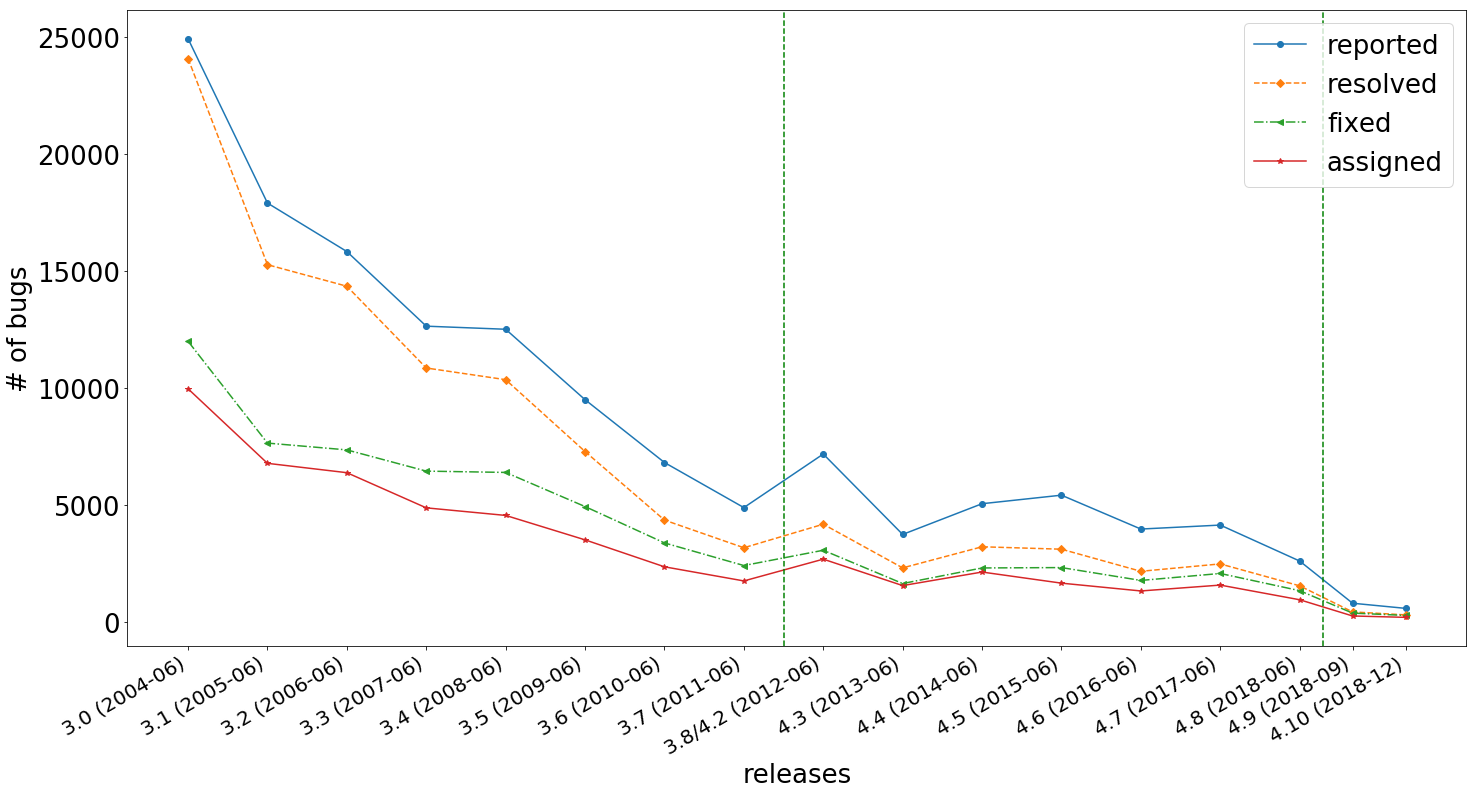

In [15]:
stats2 = stats.copy()
stats2['release'] = stats2['release'].astype(str)

stats2 = sort_df(stats2,'release')

stats2['label'] = ''
for index,row in stats2.iterrows():
    rel = row['release']
    date = relase_creation_ts_all[rel]
    date = date[:date.find(' ')]
    date = date[:date.rfind('-')]
    if rel=='4.2':
        rel='3.8/4.2'
    stats2.loc[index,'label'] = rel+' '+'('+date+')'
    
x = get_x_axis_tick_placement()

stats2 = stats2.set_index('release')

fig, ax = plt.subplots()

fig.set_figheight(13)
fig.set_figwidth(24)

ax.plot(x,stats2[['reported']],label='reported',marker='o')
ax.plot(x,stats2[['resolved']],label='resolved',marker='D',linestyle='--')
ax.plot(x,stats2[['fixed']],label='fixed',marker='<',linestyle='-.')
ax.plot(x,stats2[['assigned']],label='assigned',marker='*')
ax.legend(fontsize=26)
plt.xlabel('releases', fontsize=26)
plt.ylabel('# of bugs', fontsize=26)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    #tick.label.set_rotation(-45)
    tick.label.set_horizontalalignment('center')

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(26) 

ax.axvline(x=7.5, c='g',linestyle='--')
ax.axvline(x=14.3, c='g',linestyle='--')

plt.xticks(x, stats2.label.values.tolist())
fig.autofmt_xdate()
plt.show()


ax.get_figure().savefig('..'+os.sep+'paper'+os.sep+'figs'+os.sep+'rq1_stats.pdf', bbox_inches="tight")

# RESOLUTION STATISTICS

In [16]:
df_stat = pd.read_csv('.'+os.sep+'data'+os.sep+'bugs_info.csv',index_col=False)
df_stat=df_stat[~df_stat['resolution'].isnull()]

In [20]:
df_stat.head()

,id,release,Product,creation_time,version,resolution,is_assigned,is_resolved,is_fixed,first_assignment_date,...,last_resolved_date,first_fixed_date,last_fixed_date,time_assign_diff,time_resolve_diff,time_fix_diff,min_release,max_release,min_release_before_version_field,min_release_after_version_field
0,475361,4.5,Platform,2015-08-19 10:50:25,4.5,FIXED,0,1,1,NaN,...,2015-08-19 11:53:03,2015-08-19 11:53:03,2015-08-19 11:53:03,NaN,0.0,0.0,4.5,4.5,False,False
1,475365,4.6,Platform,2015-08-19 11:34:37,4.6,FIXED,0,1,1,NaN,...,2015-08-26 14:29:30,2015-08-26 14:29:30,2015-08-26 14:29:30,NaN,0.0,0.0,4.6,4.6,False,False
2,475370,4.5,Platform,2015-08-19 12:09:06,4.5,DUPLICATE,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.5,4.5,False,False
4,475407,4.5,Platform,2015-08-19 17:06:10,4.5,FIXED,0,1,1,NaN,...,2015-08-19 17:15:25,2015-08-19 17:15:25,2015-08-19 17:15:25,NaN,0.0,0.0,4.5,4.5,False,False
5,475427,4.5,Platform,2015-08-19 21:37:59,4.5,FIXED,0,1,1,NaN,...,2015-09-28 08:47:16,2015-09-28 08:47:16,2015-09-28 08:47:16,NaN,0.0,0.0,4.5,4.5,False,False


In [40]:
dh=df_stat.copy()
len(dh)

117848

In [41]:
dh=dh.groupby('resolution')['id'].nunique().reset_index().rename(index=str,columns={'id':'bugs'})
#@Zeinab: not sure where len_resolved comes from
len_resolved = len(df_stat)
dh['proportion']= dh['bugs']/len_resolved
dh=dh[['resolution','proportion']]
dh

,resolution,proportion
0,DUPLICATE,0.186359
1,FIXED,0.553331
2,INVALID,0.073968
3,MOVED,0.000076
4,NOT_ECLIPSE,0.013959
5,WONTFIX,0.071541
6,WORKSFORME,0.100765


In [42]:
dr=df_stat.copy()
dcount=df_stat.copy()

In [43]:
dr['release'] = dr.apply(lambda x : str(assign_to_closest_minor(x['version'])), axis=1)
dr['release'] = dr['release'].astype(str)

dcount['release'] = dcount.apply(lambda x : str(assign_to_closest_minor(x['version'])), axis=1)

dcount['release'] = dcount['release'].astype(str)

In [44]:
dcount=dcount.groupby('release')['id'].count().reset_index()
dcount['total']= dcount.apply(lambda x : x['id'], axis=1)
dcount=dcount[['release','total']]
print('total',dcount.total.sum())
dcount

total 117848


,release,total
0,3.0,24101
1,3.1,16738
2,3.2,14344
3,3.3,10944
4,3.4,10688
5,3.5,7843
6,3.6,5339
7,3.7,3717
8,4.10,341
9,4.2,5261


In [45]:
dr=dr.groupby(['release','resolution']).count()[['id']].reset_index()
dr=dr.rename(columns={'id':'count'})
dr.head()

,release,resolution,count
0,3.0,DUPLICATE,5188
1,3.0,FIXED,11805
2,3.0,INVALID,2139
3,3.0,NOT_ECLIPSE,14
4,3.0,WONTFIX,2080


In [47]:
stat_resolution_release = pd.merge(dr,dcount,on=['release'],how='outer')
stat_resolution_release

,release,resolution,count,total
0,3.0,DUPLICATE,5188,24101
1,3.0,FIXED,11805,24101
2,3.0,INVALID,2139,24101
3,3.0,NOT_ECLIPSE,14,24101
4,3.0,WONTFIX,2080,24101
5,3.0,WORKSFORME,2875,24101
6,3.1,DUPLICATE,3215,16738
7,3.1,FIXED,8311,16738
8,3.1,INVALID,1587,16738
9,3.1,NOT_ECLIPSE,14,16738


In [48]:
stat_resolution_release[stat_resolution_release['release']=='3.0']['count'].sum()

24101

In [49]:
stat_resolution_release['percentage']= stat_resolution_release.apply(lambda x : x['count']*100/x['total'], axis=1)

In [50]:
stat_resolution_release=stat_resolution_release[['release','resolution','percentage']]
stat_resolution_release

,release,resolution,percentage
0,3.0,DUPLICATE,21.526078
1,3.0,FIXED,48.981370
2,3.0,INVALID,8.875150
3,3.0,NOT_ECLIPSE,0.058089
4,3.0,WONTFIX,8.630347
5,3.0,WORKSFORME,11.928966
6,3.1,DUPLICATE,19.207791
7,3.1,FIXED,49.653483
8,3.1,INVALID,9.481420
9,3.1,NOT_ECLIPSE,0.083642


In [ ]:
#stat_resolution_release.plot.bar();

# general stats

In [51]:
def get_bug_statistics_per_release(df_w,only_one_year):
    #Calculate general stastics per release
    df_ret=pd.DataFrame()
    df_w['release'] = df_w['release'].astype(str)   
        
    for version in df_w.release.unique():
        start_date = relase_creation_ts_all[version]
        start_date = pd.to_datetime(start_date)
        end_date_before=addYears(start_date,-1)
        end_date_after=addYears(start_date,1)
        #Fetch the bugs of this version
        version_bugs = df_w[df_w['release']==version]
        version_bugs = trans_to_datetime(version_bugs,
                                        ['creation_time'])
        total=len(version_bugs.id.unique())
        if only_one_year:

            #the bug before release 
            bugs_before_release = version_bugs[(version_bugs['creation_time']<start_date) & (version_bugs['creation_time']>=end_date_before) ]

            #the bug after release 
            bugs_after_release = version_bugs[(version_bugs['creation_time']>= start_date) & (version_bugs['creation_time']< end_date_after)]
            
        
        else:
            #the bug before release 
            bugs_before_release = version_bugs[version_bugs['creation_time']<start_date]

            #the bug after release 
            bugs_after_release = version_bugs[version_bugs['creation_time']>= start_date]



        
        before_release = len(bugs_before_release.id.unique())
   

        after_release = len(bugs_after_release.id.unique())
        if only_one_year:
            total=before_release+after_release
 

        df_ret=df_ret.append({"release": version , 
                           "total": total ,
                           'before_release': before_release, 
                           'after_release':after_release, 
                        },
                         ignore_index=True)
    return df_ret

In [52]:
post_pre_df = pd.read_csv('.'+os.sep+'data'+os.sep+'bugs_info.csv',index_col=False)
post_pre_df = post_pre_df.fillna('')
post_pre_df['release'] = post_pre_df.apply(lambda x : str(assign_to_closest_minor(x['version'])), axis=1)
post_pre_df['release'] = post_pre_df['release'].astype(str)
post_pre_df['release'] = post_pre_df['release'].apply(lambda x: '4.2' if x == '3.8' else x )

In [53]:
post_pre_df.release.unique()

array(['4.5', '4.6', '4.4', '3.7', '4.2', '4.3', '3.6', '4.8', '3.1',
       '4.7', '4.10', '3.4', '3.5', '3.3', '3.2', '3.0', '4.9'],
      dtype=object)

In [54]:
post_pre_df_year=get_bug_statistics_per_release(post_pre_df,True)
post_pre_df=get_bug_statistics_per_release(post_pre_df,False)
post_pre_df = sort_df(post_pre_df,'release')

/Users/econst/Repositories/publications/eclipse-zeinab/msr2019/rep-pack/global_functions.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dd[col] = pd.to_datetime(dd[col])


In [55]:
post_pre_df

,release,after_release,before_release,total
0,3.0,6970.0,17967.0,24937.0
1,3.1,5718.0,12190.0,17908.0
2,3.2,5354.0,10480.0,15834.0
3,3.3,4550.0,8092.0,12642.0
4,3.4,4579.0,7931.0,12510.0
5,3.5,2699.0,6798.0,9497.0
6,3.6,2292.0,4518.0,6810.0
7,3.7,1957.0,2925.0,4882.0
8,4.2,3708.0,3465.0,7173.0
9,4.3,1824.0,1910.0,3734.0


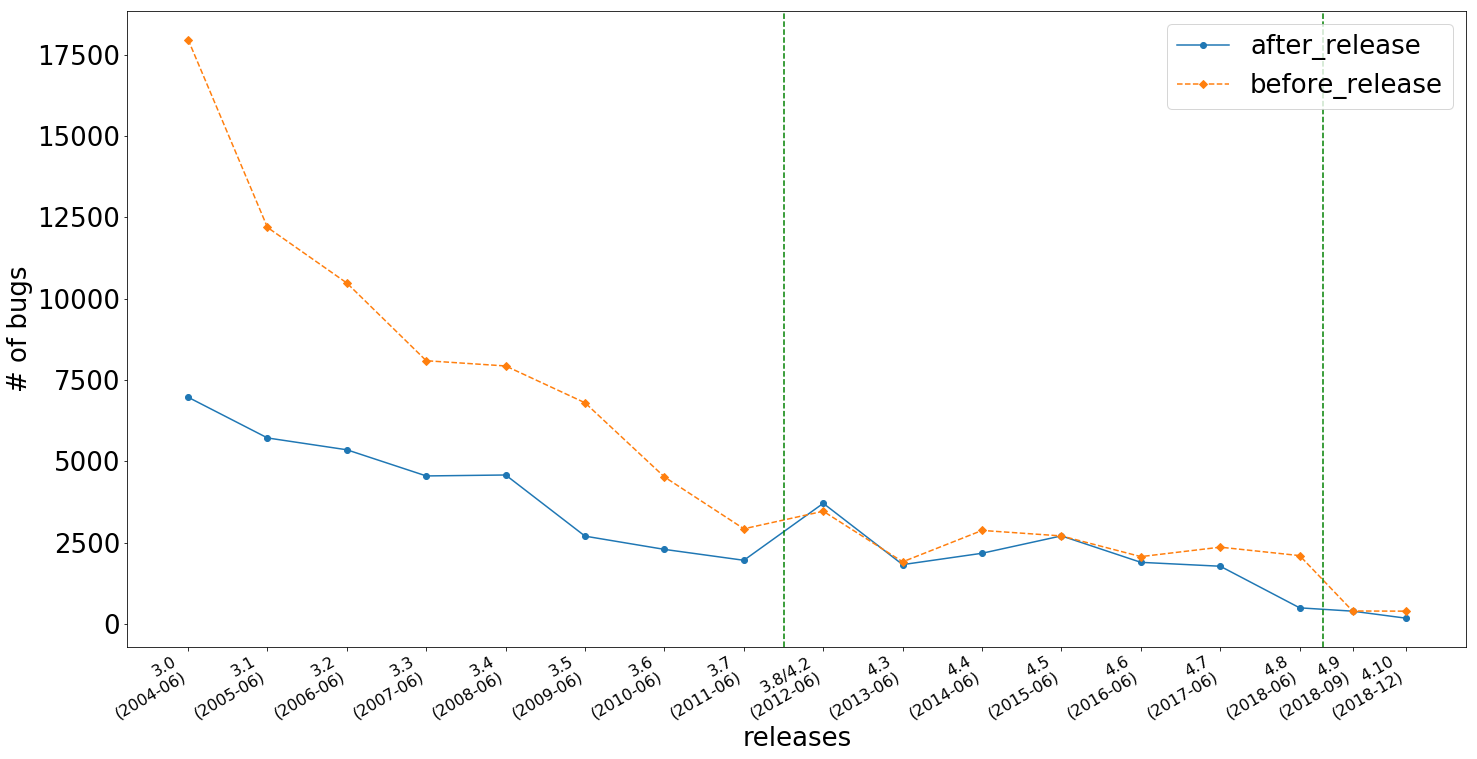

In [60]:
stats2 = post_pre_df.copy()
stats2['release'] = stats2['release'].astype(str)

stats2 = sort_df(stats2,'release')
x = get_x_axis_tick_placement()
stats2['label'] = ''

for index,row in stats2.iterrows():
    rel = row['release']
    date = relase_creation_ts_all[rel]
    date = date[:date.find(' ')]
    date = date[:date.rfind('-')]
    if rel=='4.2':
        rel='3.8/4.2'
    stats2.loc[index,'label'] = rel+'\n'+'('+date+')'

stats2 = stats2.set_index('release')

fig, ax = plt.subplots()

fig.set_figheight(13)
fig.set_figwidth(24)

ax.plot(x,stats2[['after_release']],label='after_release',marker='o')
ax.plot(x,stats2[['before_release']],label='before_release',marker='D',linestyle='--')


ax.legend(fontsize=26,loc=1)
plt.xlabel('releases', fontsize=26)
plt.ylabel('# of bugs', fontsize=26)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
    tick.label.set_horizontalalignment('center')

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(26) 

ax.axvline(x=7.5, c='g',linestyle='--')
ax.axvline(x=14.3, c='g',linestyle='--')


plt.xticks(x, stats2.label.values.tolist())
fig.autofmt_xdate()
plt.show()

ax.get_figure().savefig('..'+os.sep+'paper'+os.sep+'figs'+os.sep+'rq1_stats_before&after.pdf', bbox_inches="tight")

# STAT ON RATIO OF REPORTED BUGS OF BEFORE AND AFTER A RELEASE

In [42]:
ratio_stat=post_pre_df.copy()
ratio_stat.head()

,release,after_release,before_release,total
0,3.0,6970.0,17967.0,24937.0
1,3.1,5718.0,12190.0,17908.0
2,3.2,5354.0,10480.0,15834.0
3,3.3,4550.0,8092.0,12642.0
4,3.4,4579.0,7931.0,12510.0


In [43]:
ratio_stat['ratio']=ratio_stat['after_release']/ratio_stat['before_release']
ratio_stat=sort_df(ratio_stat,'release')
ratio_stat

,release,after_release,before_release,total,ratio
0,3.0,6970.0,17967.0,24937.0,0.387933
1,3.1,5718.0,12190.0,17908.0,0.469073
2,3.2,5354.0,10480.0,15834.0,0.510878
3,3.3,4550.0,8092.0,12642.0,0.562284
4,3.4,4579.0,7931.0,12510.0,0.577355
5,3.5,2699.0,6798.0,9497.0,0.397029
6,3.6,2292.0,4518.0,6810.0,0.507304
7,3.7,1957.0,2925.0,4882.0,0.669060
8,4.2,3708.0,3465.0,7173.0,1.070130
9,4.3,1824.0,1910.0,3734.0,0.954974


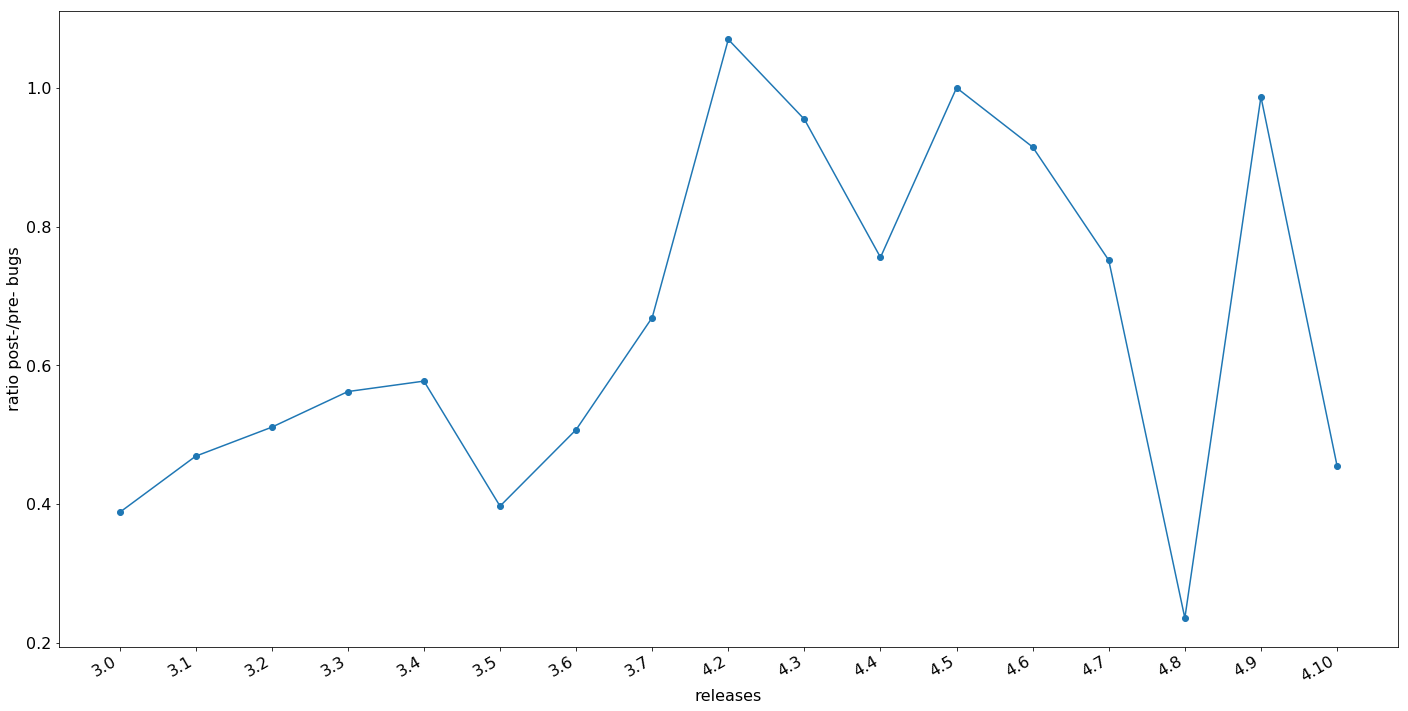

In [58]:
fig, ax = plt.subplots()

fig.set_figheight(13)
fig.set_figwidth(24)

ax.plot(ratio_stat['release'],ratio_stat['ratio'],label='ratio_after_before',marker='o')
plt.xlabel('releases', fontsize=16)
plt.ylabel('ratio post-/pre- bugs', fontsize=16)


for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
    tick.label.set_horizontalalignment('center')

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 

fig.autofmt_xdate()

plt.show()
ax.get_figure().savefig('..'+os.sep+'paper'+os.sep+'Ωtemp_figs'+os.sep+'5_ratio_after_before.pdf', bbox_inches="tight")

In [61]:
#latex=ratio_stat[['release','ratio']]
#print(latex.to_latex(index=False))

\begin{tabular}{lr}
\toprule
release &     ratio \\
\midrule
    3.0 &  0.387933 \\
    3.1 &  0.469073 \\
    3.2 &  0.510878 \\
    3.3 &  0.562284 \\
    3.4 &  0.577355 \\
    3.5 &  0.397029 \\
    3.6 &  0.507304 \\
    3.7 &  0.669060 \\
    4.2 &  1.070130 \\
    4.3 &  0.954974 \\
    4.4 &  0.755826 \\
    4.5 &  1.000370 \\
    4.6 &  0.914976 \\
    4.7 &  0.751695 \\
    4.8 &  0.235602 \\
    4.9 &  0.987437 \\
   4.10 &  0.455471 \\
\bottomrule
\end{tabular}



# STAT ON RATIO OF REPORTED/ASSIGNED BUGS OF BEFORE AND AFTER A RELEASE

In [62]:
stats_FR=stats.copy()

In [64]:
stats_FR['ratio_resolved']=stats_FR['resolved']/stats_FR['reported']
stats_FR['ratio_fixed']=stats_FR['fixed']/stats_FR['resolved']
stats_FR=sort_df(stats_FR,'release')
latex_FR=stats_FR[['release','ratio_resolved','ratio_fixed']]

In [65]:
stats_FR.head()

,release,reported,resolved,assigned,fixed,ratio_resolved,ratio_fixed
0,3.0,24937,24088,9963,11995,0.965954,0.497966
1,3.1,17908,15272,6775,7641,0.852803,0.500327
2,3.2,15834,14350,6375,7350,0.906278,0.512195
3,3.3,12642,10853,4871,6442,0.858488,0.593569
4,3.4,12510,10353,4547,6386,0.827578,0.616826


In [66]:
print(latex_FR.to_latex(index=False))

\begin{tabular}{lrr}
\toprule
release &  ratio\_resolved &  ratio\_fixed \\
\midrule
    3.0 &        0.965954 &     0.497966 \\
    3.1 &        0.852803 &     0.500327 \\
    3.2 &        0.906278 &     0.512195 \\
    3.3 &        0.858488 &     0.593569 \\
    3.4 &        0.827578 &     0.616826 \\
    3.5 &        0.766558 &     0.676648 \\
    3.6 &        0.638326 &     0.775247 \\
    3.7 &        0.648095 &     0.759482 \\
    4.2 &        0.581486 &     0.732918 \\
    4.3 &        0.616765 &     0.709509 \\
    4.4 &        0.635103 &     0.717405 \\
    4.5 &        0.573065 &     0.746615 \\
    4.6 &        0.544147 &     0.818730 \\
    4.7 &        0.598210 &     0.834614 \\
    4.8 &        0.591294 &     0.865147 \\
    4.9 &        0.530973 &     0.878571 \\
   4.10 &        0.512238 &     0.918089 \\
\bottomrule
\end{tabular}



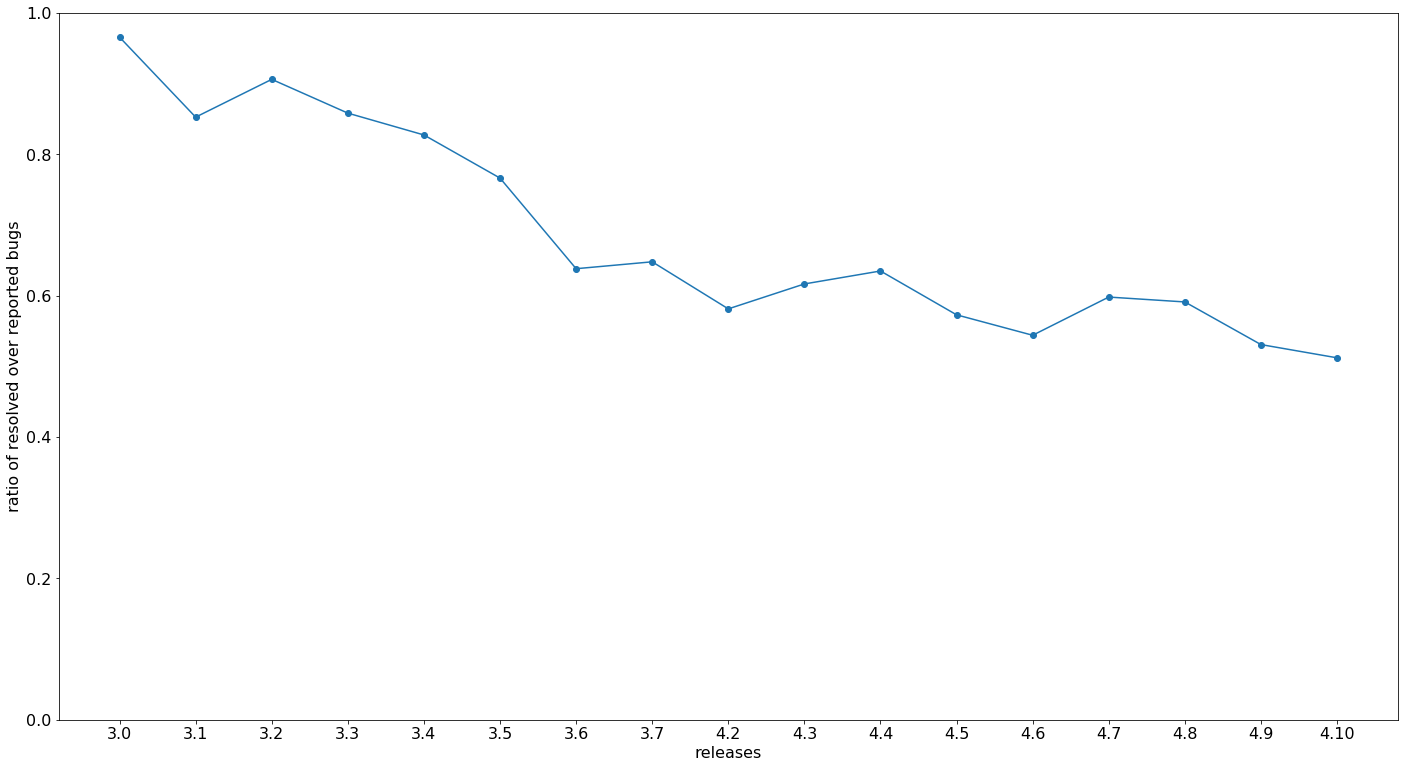

In [70]:
fig, ax = plt.subplots()

fig.set_figheight(13)
fig.set_figwidth(24)

ax.plot(stats_FR['release'],stats_FR['ratio_resolved'],label='ratio_resolved',marker='o')
plt.xlabel('releases', fontsize=16)
plt.ylabel('ratio of resolved over reported bugs', fontsize=16)
plt.ylim(0,1)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
    tick.label.set_horizontalalignment('center')

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 


plt.show()
ax.get_figure().savefig('..'+os.sep+'paper'+os.sep+'temp_figs'+os.sep+'5_ratio_resolved.pdf', bbox_inches="tight")

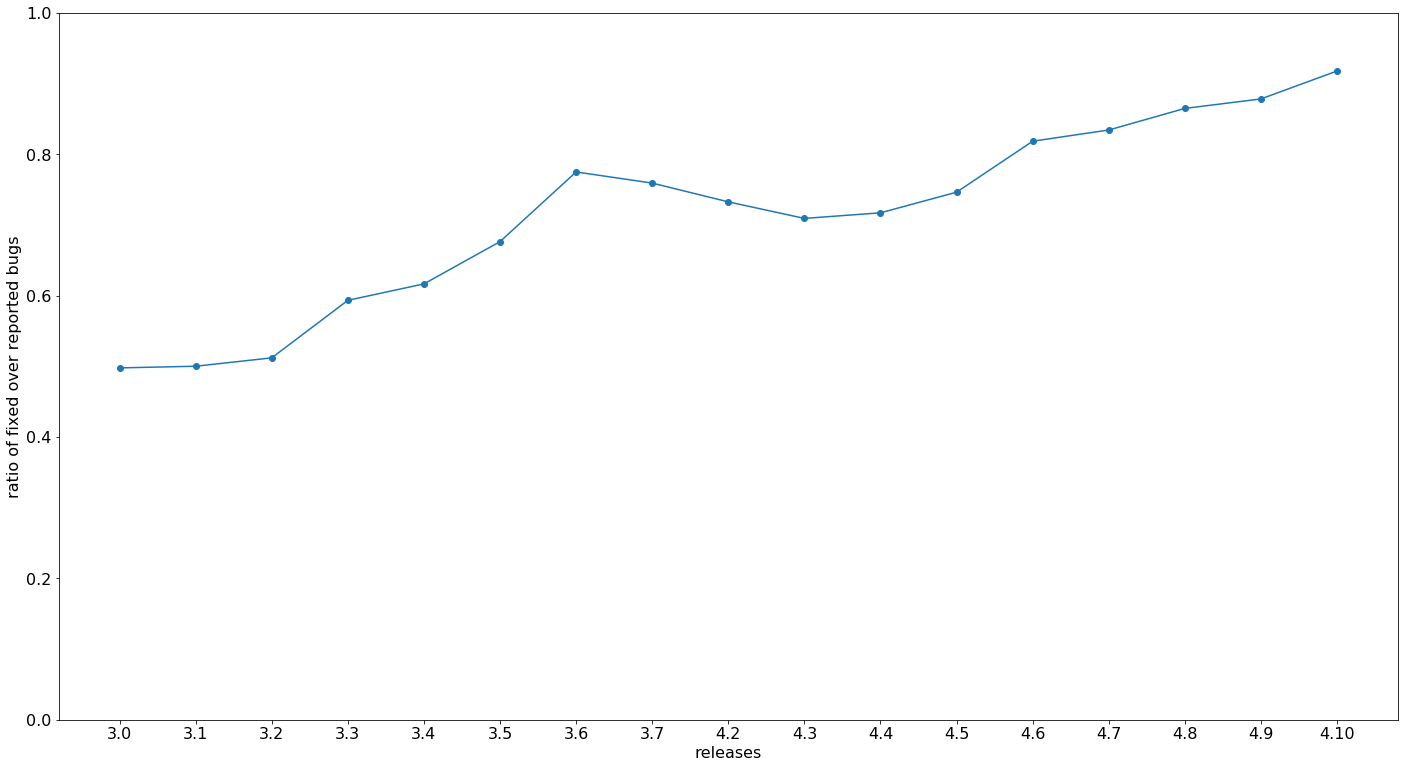

In [71]:
fig, ax = plt.subplots()

fig.set_figheight(13)
fig.set_figwidth(24)

ax.plot(stats_FR['release'],stats_FR['ratio_fixed'],label='ratio_fixed',marker='o')
plt.xlabel('releases', fontsize=16)
plt.ylabel('ratio of fixed over reported bugs', fontsize=16)
plt.ylim(0,1)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
    tick.label.set_horizontalalignment('center')

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 


plt.show()
ax.get_figure().savefig('..'+os.sep+'paper'+os.sep+'temp_figs'+os.sep+'5_ratio_fixed.pdf', bbox_inches="tight")